In [ ]:

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
import itertools
import statsmodels.api as sm
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
#On fixe aujourd'hui comme la date de la fin 
end_date = datetime.today()

#Sla date de la fin 4 ans en arriere
start_date = datetime(end_date.year-4,end_date.month,end_date.day)
#using yahoo finance to grab cryptocurrency data

BTC = pdr.DataReader('BTC-USD','yahoo',start_date,end_date)#Bitcoin
ETH = pdr.DataReader('ETH-USD','yahoo',start_date,end_date)#Ethereum
LTC = pdr.DataReader('LTC-USD','yahoo',start_date,end_date)#Litecon

In [ ]:
df=BTC
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-21,678.669983,587.482971,665.914978,596.116028,2.663930e+08,596.116028
2016-06-22,629.327026,558.138977,597.442993,623.976990,2.534620e+08,623.976990
2016-06-23,681.726990,625.271973,625.575012,665.299011,2.243170e+08,665.299011
2016-06-24,691.731018,646.559021,665.281006,665.122986,1.266560e+08,665.122986
2016-06-25,665.979980,616.934021,665.931030,629.367004,1.092250e+08,629.367004
...,...,...,...,...,...,...
2020-06-16,9540.422852,9327.339844,9533.784180,9480.254883,2.017771e+10,9480.254883
2020-06-17,9482.782227,9328.395508,9481.567383,9411.840820,1.777008e+10,9411.840820
2020-06-18,9440.875977,9274.295898,9410.293945,9288.018555,1.963222e+10,9288.018555


In [ ]:
df=df.drop(df.columns[[0,1,2,4,5]],axis='columns')
df.tail()

,Close
Date,
2020-06-16,9480.254883
2020-06-17,9411.840820
2020-06-18,9288.018555
2020-06-20,9303.629883
2020-06-22,9649.010742


In [ ]:
#Lorsque nous travaillons avec des données de séries chronologiques en Python, nous devons nous assurer que les dates sont utilisées comme index, 

df.index

DatetimeIndex(['2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24',
               '2016-06-25', '2016-06-26', '2016-06-27', '2016-06-28',
               '2016-06-29', '2016-06-30',
               ...
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-20', '2020-06-22'],
              dtype='datetime64[ns]', name='Date', length=1461, freq=None)

In [ ]:
df.head()


,Close
Date,
2016-06-21,596.116028
2016-06-22,623.976990
2016-06-23,665.299011
2016-06-24,665.122986
2016-06-25,629.367004


In [ ]:
df.dtypes 
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2016-06-21 to 2020-06-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1461 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


,Close
count,1461.000000
mean,5826.687081
std,3749.460271
min,547.465027
25%,2518.560059
50%,6377.779785
75%,8595.740234
max,19497.400391


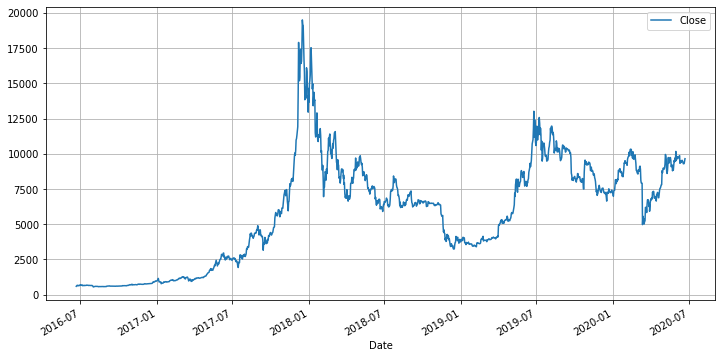

In [ ]:
viz = df.plot(y= 'Close', figsize=(12,6), legend=True, grid=True, use_index=True)
plt.show()

In [ ]:
price = df['Close']

#La première étape : 

Pour construire un modèle ARIMA, il faut rendre les séries chronologiques stationnaires. 

En effet, le terme «auto-régressif» dans ARIMA signifie qu'il s'agit d'un modèle de régression linéaire qui utilise ses propres décalages comme prédicteurs. 

Les modèles de régression linéaire fonctionnent mieux lorsque les prédicteurs ne sont pas corrélés et sont indépendants les uns des autres.

On va d'abord vérifier si la série est stationnaire en utilisant le test Augmented Dickey Fuller (adfuller ()).

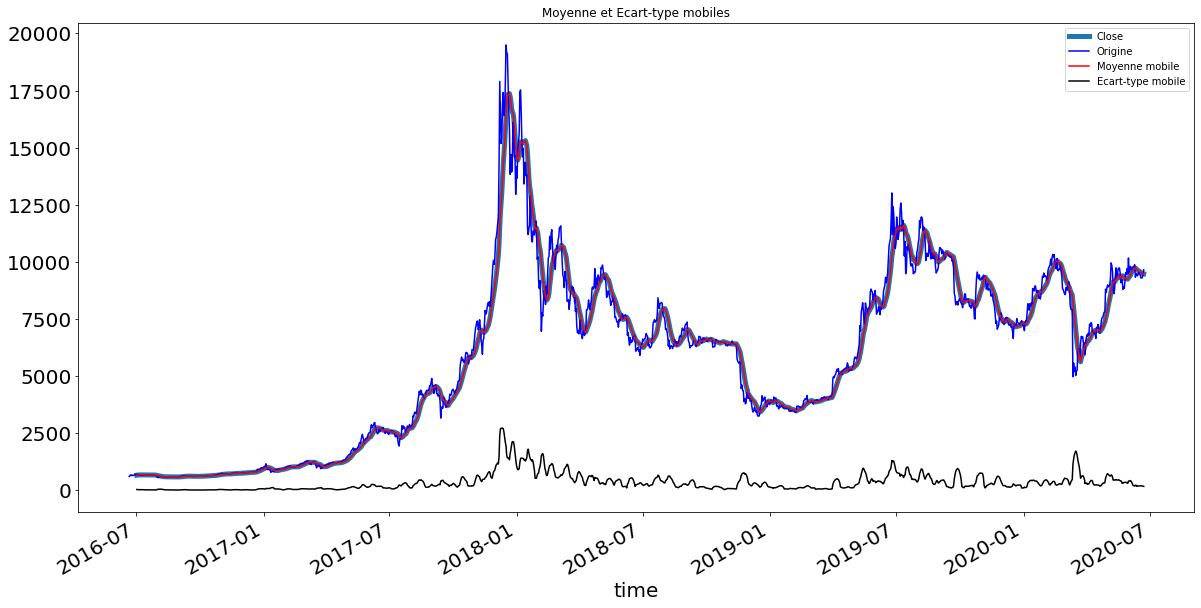

In [ ]:
#Statistiques roulantes : L'objectif est de tracer la moyenne mobile et l’écart-type mobile. 
#La série temporelle est stationnaire si elle reste constante dans le temps. 

price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('time', fontsize=20);

rolling_mean = price.rolling(window = 12).mean()
rolling_std = price.rolling(window = 12).std()

plt.plot(price, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

#Test de Dickey-Fuller augmenté (ADF) :

L'hypothèse nulle du test ADF est que la série chronologique n'est pas stationnaire.

Si la valeur de p du test est inférieure au niveau de signification (0,05), on rejette l'hypothèse nulle et on déduit que la série chronologique est en effet stationnaire.

In [ ]:
Test_ADF = adfuller(price)

print('Statistiques ADF : {}'.format(Test_ADF[0]))
print('p-value : {}'.format(Test_ADF[1]))
print('Valeurs Critiques :')
for cle, valeur in Test_ADF[4].items():
    print('\t{}: {}'.format(cle, valeur))


#Problème : p valeur n'est pas faible (0,52%)
#La statistique ADF est loin des valeurs critiques et la p-value est supérieure au seuil (0,05). 
#Donc la série temporelle n’est pas stationnaire.

Statistiques ADF : -2.184685483363956
p-value : 0.21185061966902463
Valeurs Critiques :
	1%: -3.434899302257815
	5%: -2.8635492080466607
	10%: -2.567839687982253


une série non-stationnaire est une série où : il y a une tendance ; il y a une saisonnalité ; la moyenne et la variance varient dans le temps.

In [ ]:
#Comment rendre une série stationnaire? L'approche la plus courante est de soustraire la valeur précédente de la valeur actuelle. 
y=  price-price.shift()
y.dropna(inplace=True)  # dropna permet de supprimer les données manquantes car adfuller (pour le test) ne peut pas gérer les valeurs manquantes.
y.head()


Date
2016-06-22    27.860962
2016-06-23    41.322021
2016-06-24    -0.176025
2016-06-25   -35.755981
2016-06-26    25.908020
Name: Close, dtype: float64

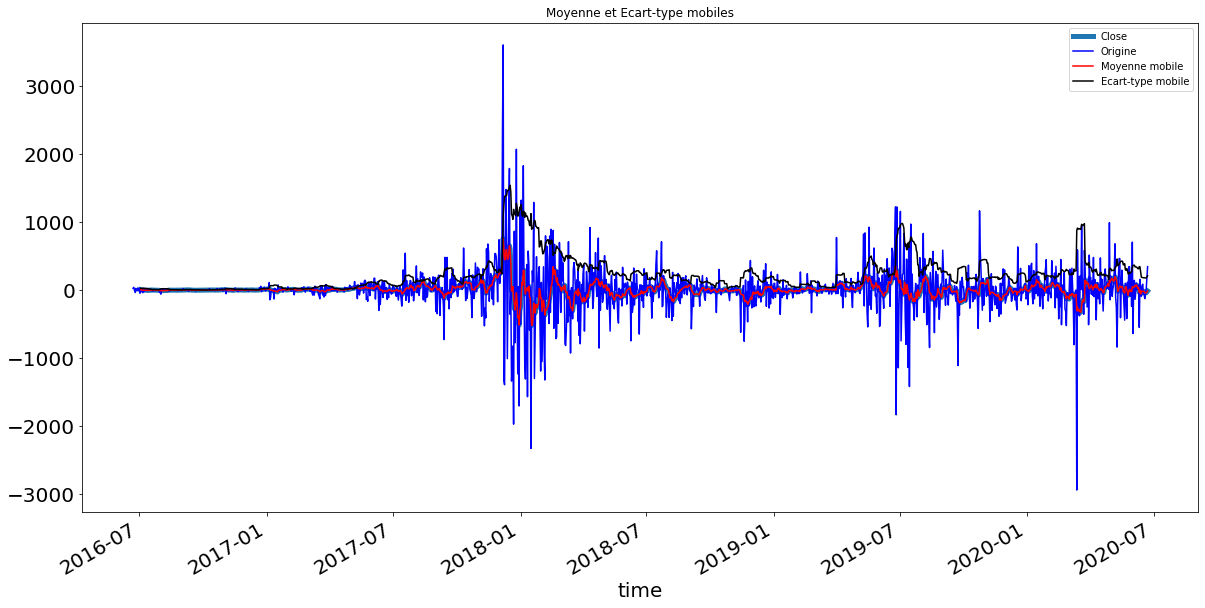

In [ ]:
y.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('time', fontsize=20);

rolling_mean = y.rolling(window = 12).mean()
rolling_std = y.rolling(window = 12).std()

plt.plot(y, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

In [ ]:
Test_ADF = adfuller(y)

print('Statistiques ADF : {}'.format(Test_ADF[0]))
print('p-value : {}'.format(Test_ADF[1]))
print('Valeurs Critiques :')
for cle, valeur in Test_ADF[4].items():
    print('\t{}: {}'.format(cle, valeur))


# p valeur est très faible, elle est bien inférieur au seuil de 0,05
#Donc la série temporelle est stationnaire.

Statistiques ADF : -7.471740498547978
p-value : 5.0337994277854675e-11
Valeurs Critiques :
	1%: -3.434899302257815
	5%: -2.8635492080466607
	10%: -2.567839687982253


Il peut être difficile de travailler avec des données hebdomadaires, alors utilisons plutôt les moyennes mensuelles de nos séries chronologiques. 

Cela peut être obtenu en utilisant la fonction de rééchantillonnage pratique, qui nous permet de regrouper les séries chronologiques en compartiments (1 mois), d'appliquer une fonction sur chaque groupe (moyenne) et de combiner le résultat (une ligne par groupe).

In [ ]:
price = y.resample('MS').mean()
price.head()

Date
2016-06-01    8.908888
2016-07-01   -2.258840
2016-08-01   -1.095774
2016-09-01    1.389333
2016-10-01    2.899634
Freq: MS, Name: Close, dtype: float64

In [ ]:
price.isnull().sum() #Nombre de données manquantes 

0

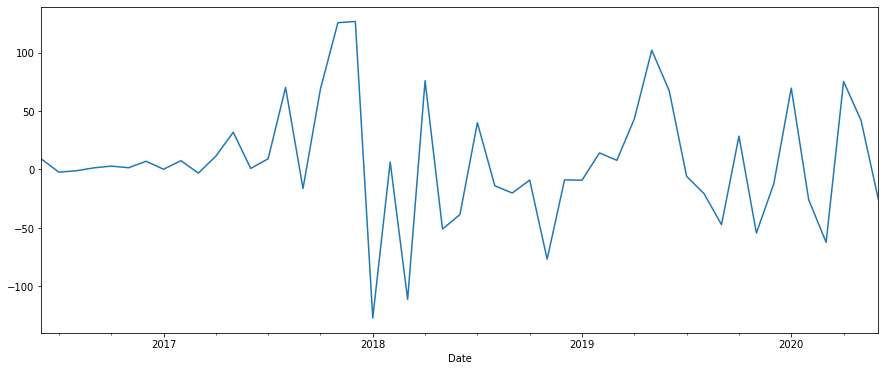

In [ ]:
price.plot(figsize=(15, 6))
plt.show()

#Décomposition

La décomposition en séries chronologiques permet d'identifier plus facilement un changement de moyenne ou de variation des données.

Le graphique ci-dessus montre clairement la saisonnalité annuelle.

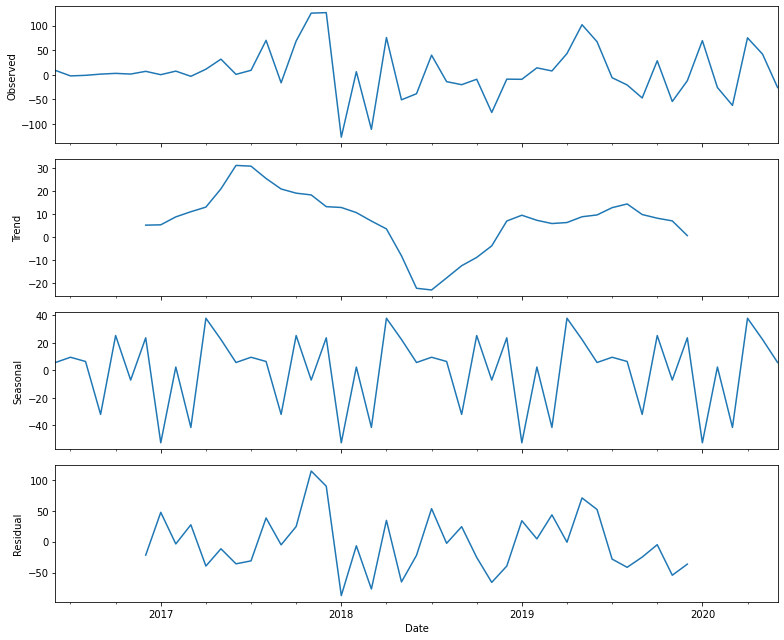

In [ ]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(price, model='additive')
decomposition_plot = decomposition.plot()
plt.show()

#ARIMA :

C'est une classe de modèle qui capture une suite de différentes structures temporelles standard dans des données de séries chronologiques.

AR: autorégression. C'est un modèle qui utilise la relation dépendante entre une observation et un certain nombre d'observations décalées.

MA : Moyenne mobile. C'est un modèle qui utilise la dépendance entre une observation et une erreur résiduelle d'un modèle de moyenne mobile appliqué aux observations décalées.

ARIMA est l'une des techniques les plus utilisées pour l'analyse des séries chronologiques.

Trois entiers distincts (p, d, q) sont utilisés pour paramétrer les modèles ARIMA. Pour cette raison, les modèles ARIMA sont désignés par la notation ARIMA (p, d, q). Ensemble, ces trois paramètres expliquent la saisonnalité, la tendance et le bruit dans les ensembles de données:

- p est la partie auto-régressive du modèle. Il nous permet d'intégrer l'effet des valeurs passées dans notre modèle. Intuitivement, cela reviendrait à dire qu'il est probable qu'il fera chaud demain s'il a fait chaud au cours des 3 derniers jours.

- d est la partie intégrée du modèle. Cela comprend les termes du modèle qui intègrent la quantité de différenciation (c'est-à-dire le nombre de points de temps passés à soustraire de la valeur actuelle) à appliquer à la série chronologique. Intuitivement, cela reviendrait à dire qu'il est probable que ce sera la même température demain si la différence de température au cours des trois derniers jours a été très faible.

- q est la partie moyenne mobile du modèle. Cela nous permet de définir l'erreur de notre modèle comme une combinaison linéaire des valeurs d'erreur observées à des moments antérieurs dans le passé.

Malgré le fait que le méthode ARIMA puisse gérer la tendance des données, elle ne prend pas en charge les séries chronologiques avec une composante saisonnière.


#SARIMA

SARIMA est une extension de la méthode ARIMA. Cette méthode permet la prévision des séries chronologiques avec des données univariées contenant des tendances et la saisonnabilité.

Comment configurer le modèle SARIMA

La configuration d'un SARIMA nécessite la sélection d'hyperparamètres pour les éléments de tendance et saisonniers de la série.

Éléments de tendance
Trois éléments de tendance nécessitent une configuration. Ils sont les mêmes que le modèle ARIMA :
- p: Ordre d'autorégression des tendances. d: Ordre de différence de tendance. - q: Tendance de l'ordre moyen mobile.

Éléments saisonniers
Il y a quatre éléments saisonniers qui ne font pas partie d'ARIMA qui doivent être configurés :
- P: Ordre autorégressif saisonnier. D: Ordre de différence saisonnière. Q: Ordre moyen saisonnier mobile. s: Le nombre de pas de temps pour une seule période saisonnière.
- s = 1 par an ; 4 pour trimestriel ; 12 pour mensuel ; 52 pour hebdomadaire ; 365 pour tous les jours

In [ ]:
# On va générer les différentes combinaisons de paramètres (p, d et q) qui peuvent prendre n'importe quelles valeurs entre 0 et 2 : 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
parametre_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#AIC :

Les critères d'information d'Akaike (AIC) sont une mesure largement utilisée pour un modèle statistique.
Il quantifie essentiellement : la qualité de l'ajustement et la simplicité / parcimonie du modèle en une seule statistique.
Lorsque l'on compare deux modèles, celui avec l'AIC inférieur est généralement «meilleur».

Pour chaque combinaison de paramètres, on va avoir un nouveau modèle SARIMA
Les paramètres optimaux seront ceux qui donneront les meilleures performances pour nos critères d’intérêt.

In [ ]:
#On va chercher les valeurs p,d,q de notre modèle SARIMA qui permet d'avoir le plus petit AIC 

warnings.filterwarnings("ignore") # ingorer les messages d'avertissement 

for parametre in pdq:
    for parametre_seasonal in parametre_pdq:
        try:
            model_SARIMA = sm.tsa.statespace.SARIMAX(price, order=parametre, seasonal_order=parametre_seasonal, enforce_stationarity=False,  enforce_invertibility=False)

            resultats = model_SARIMA.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(parametre, parametre_seasonal, resultats.aic))
        except:
            continue

#La sortie du modèle est ; ARIMA ARIMA(1, 1, 1)x(1, 1, 0, 12)12 et  la valeur AIC la plus faible est 266.1883031218111
#Parmi tous les modèles examinés c'est le plus optimal 

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:517.9195864541166
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:400.74745602328176
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:422.2806239477423
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:410.8685885846952
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:400.29229987433257
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:281.46520894082073
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:510.15235364605985
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:392.66132634403647
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:413.21776068184056
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1090.9188596363365
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:412.8684329050092
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:392.26011114508117
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:283.0927763331765
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:261.85949887803395
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:540.0344699547779
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1330.5169579009596
ARIMA(0, 1, 0)x(0, 1, 0, 12)

* order = l'ordre (p, d, q) du modèle pour le nombre de paramètres AR, les différences et les paramètres MA.
* seasonal_order = l'ordre (P, D, Q, s) de la composante saisonnière du modèle pour les paramètres AR, les différences, les paramètres MA et la périodicité.
* enforce_stationarity=False : Cela indique s'il faut ou non transformer les paramètres AR pour appliquer la stationnarité dans la composante autorégressive du modèle. La valeur par défaut est True.
* enforce_invertibility=False) : Cela indique s'il faut ou non transformer les paramètres MA pour appliquer l'invertibilité dans la composante moyenne mobile du modèle. La valeur par défaut est True.

#3ème étape : Le modèle

In [ ]:
model = sm.tsa.statespace.SARIMAX(price,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False, enforce_invertibility=False)
arima = model.fit()
print(arima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                   49
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -129.042
Date:                            Mon, 22 Jun 2020   AIC                            266.083
Time:                                    23:04:06   BIC                            270.625
Sample:                                06-01-2016   HQIC                           267.225
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1490      0.261      0.571      0.568      -0.363       0.661
ma.L1         -1.0000      0.305   

Notre principale préoccupation est de nous assurer que les résidus de notre modèle ne sont pas corrélés et normalement distribués avec une moyenne nulle.

Si le modèle saisonnier ARIMA ne satisfait pas ces propriétés, c'est une bonne indication qu'il peut être encore amélioré.

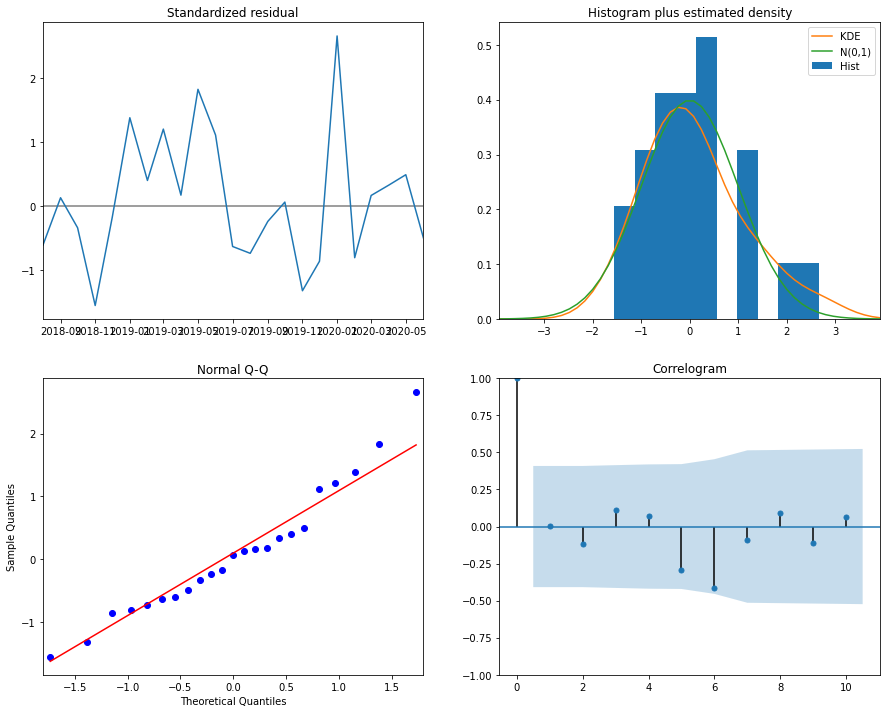

In [ ]:
arima.plot_diagnostics(figsize=(15, 12))
plt.show()


#Dans le graphique en haut à droite, nous voyons que la ligne KDE orange suit de près la ligne N (0,1) 
#C'est une bonne indication que les résidus sont normalement distribués.

#Le graphique qq en bas à gauche montre que la distribution ordonnée des résidus (points bleus) suit un peu près la tendance linéaire des échantillons prélevés 
#dans une distribution normale standard avec N (0, 1). Encore une fois, cela indique que les résidus sont normalement distribués.

#en bas à droite, qui montre que les résidus de séries chronologiques ont une faible corrélation avec les versions décalées de lui-même.

On va comparer les valeurs prédites aux valeurs réelles de la série chronologique, ce qui nous aidera à comprendre l'exactitude de nos prévisions.

Les attributs get_prediction () et conf_int () nous permettent d'obtenir les valeurs et les intervalles de confiance associés pour les prévisions de la série chronologique.

On va commencer à predire à partir du 1 janvier 2018

In [ ]:
prediction = arima.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
prediction_intervalle = prediction.conf_int() #Permet de construire un intervalle de confiance pour les paramètres ajustés.

#L'argument dynamic = False garantit que nous produisons des prévisions à une étape,
#ce qui signifie que les prévisions à chaque point sont générées en utilisant l'historique complet jusqu'à ce point.

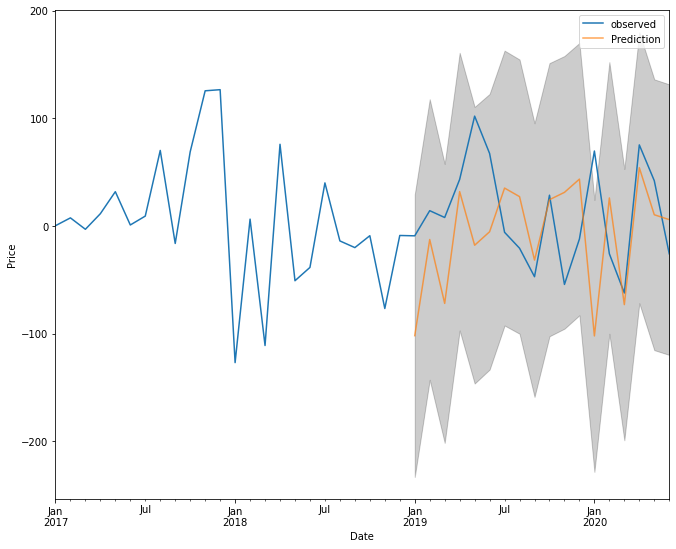

In [ ]:
pred = price['2017':].plot(label='observed')
prediction.predicted_mean.plot(ax=pred, label='Prediction', alpha=.7)

pred.fill_between(prediction_intervalle.index, prediction_intervalle.iloc[:, 0], prediction_intervalle.iloc[:, 1], color='k', alpha=.2)

pred.set_xlabel('Date')
pred.set_ylabel('Price')
plt.legend()

plt.show()

#Dans l'ensemble, nos prévisions ne s'alignent pas trop à la réalité. 
#Cependant la dernière hausse de  2020 a bien été anticipé par le model 

In [ ]:
#L'attribut get_forecast () de notre objet de série chronologique peut calculer les valeurs prévues pour un nombre spécifié d'étapes à venir.

forecast = arima.get_forecast(steps=10)
forecast_intervalle = forecast.conf_int()

In [ ]:
print(forecast_intervalle)

            lower Close  upper Close
2020-07-01  -116.634294   134.427480
2020-08-01  -152.577280   102.656594
2020-09-01  -167.158625    88.374948
2020-10-01  -128.246786   127.324395
2020-11-01  -202.415357    53.161272
2020-12-01  -145.612363   109.965074
2021-01-01  -110.658263   144.919294
2021-02-01  -138.406149   117.171426
2021-03-01  -157.668601    97.908977
2021-04-01   -78.330590   177.246989


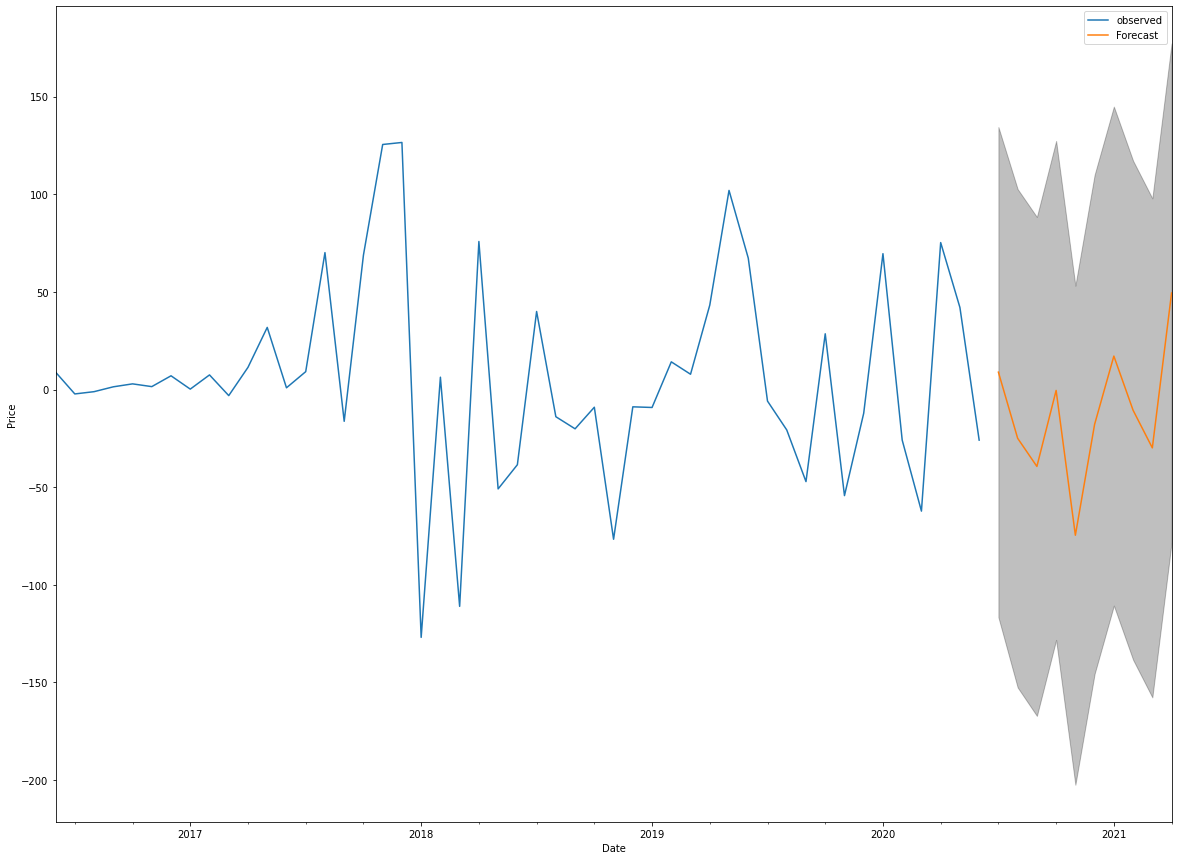

In [ ]:
ax = price.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_intervalle.index, forecast_intervalle.iloc[:, 0], forecast_intervalle.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [ ]:
forecast_intervalle
forecast=(forecast_intervalle["lower Close"]+forecast_intervalle["upper Close"]) /2
forecast

2020-07-01     8.896593
2020-08-01   -24.960343
2020-09-01   -39.391838
2020-10-01    -0.461195
2020-11-01   -74.627042
2020-12-01   -17.823644
2021-01-01    17.130515
2021-02-01   -10.617362
2021-03-01   -29.879812
2021-04-01    49.458200
Freq: MS, dtype: float64

In [ ]:
predc =(prediction_intervalle["lower Close"]+ prediction_intervalle["upper Close"]) /2
#print(predc)

#Metrics

L'erreur quadratique moyenne, ou MSE, est calculée comme la moyenne des valeurs d'erreur quadratique de prévision.

La quadrature des valeurs d'erreur de prévision les oblige à être positives; cela a également pour effet de mettre plus de poids sur les grosses erreurs.
Les erreurs de prévision très importantes ou aberrantes sont au carré, ce qui à son tour a pour effet de faire glisser la moyenne des erreurs de prévision au carré, ce qui entraîne un score d'erreur quadratique moyen plus élevé.
En effet, le score donne de moins bonnes performances aux modèles qui font de grosses prévisions erronées.

Les valeurs d'erreur sont en unités carrées des valeurs prédites. Une erreur quadratique moyenne de zéro indique une compétence parfaite ou aucune erreur.

In [ ]:
#Metrics 
print('SARIMA model MSE:{}'.format(mean_squared_error(price['2019-01-01':],predc)))

#MSE est elevé donc le modèle ne prédit pas bien 

SARIMA model MSE:4715.665960970784


#Out-of-Time cross-validation : la validation croisée hors du temps

Dans la validation croisée hors du temps, nous allons effectuer quelques pas en arrière dans le temps et prévoire dans le futur autant d'étapes que nous avons prises en arrière. Ensuite, on va comparer les prévisions aux chiffres réels.

Pour effectuer une validation croisée hors du temps, on doit créer un ensemble de données d'apprentissage et de test en divisant la série chronologique en 2 parties.

In [ ]:
price = df['Close']
y =  price-price.shift()
y.dropna(inplace=True)  

#split data au hasard
train, test=y[:-40], y[-40:]

#Train 
train = train.resample('MS').mean()
#Test 
test = test.resample('MS').mean()

In [ ]:
# On va générer les différentes combinaisons de paramètres (p, d et q) qui peuvent prendre n'importe quelles valeurs entre 0 et 2 : 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
parametre_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


#On va chercher les valeurs p,d,q de notre modèle SARIMA qui permet d'avoir le plus petit AIC 
warnings.filterwarnings("ignore") # ingorer les messages d'avertissement 
for parametre in pdq:
    for parametre_seasonal in parametre_pdq:
        try:
            model_SARIMA = sm.tsa.statespace.SARIMAX(train, order=parametre, seasonal_order=parametre_seasonal, enforce_stationarity=False,  enforce_invertibility=False)

            resultats = model_SARIMA.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(parametre, parametre_seasonal, resultats.aic))
        except:
            continue

#La sortie du modèle est ; ARIMA(1, 1, 1)x(1, 1, 0, 12)12  et  la valeur AIC la plus faible est 255.45977691486672

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:507.28808511563096
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1197.1893145664376
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:411.48780751101225
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:400.0527983827167
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1272.535056476258
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:270.95923476236004
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:499.52285477755385
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1050.6780769284178
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:402.5746569047671
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:402.0340992268725
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1096.8976287123746
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:272.58794271397164
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:529.7187899819864
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1692.2226603766005
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:420.6276560308222
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:414.8301887012898
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1493.0853010121837
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:273.6024397967906


In [ ]:
model = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),enforce_stationarity=False, enforce_invertibility=False)
arima = model.fit()
print(arima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -123.730
Date:                            Mon, 22 Jun 2020   AIC                            255.460
Time:                                    23:05:01   BIC                            259.824
Sample:                                06-01-2016   HQIC                           256.488
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1474      0.266      0.554      0.580      -0.374       0.669
ma.L1         -1.0000      0.319   

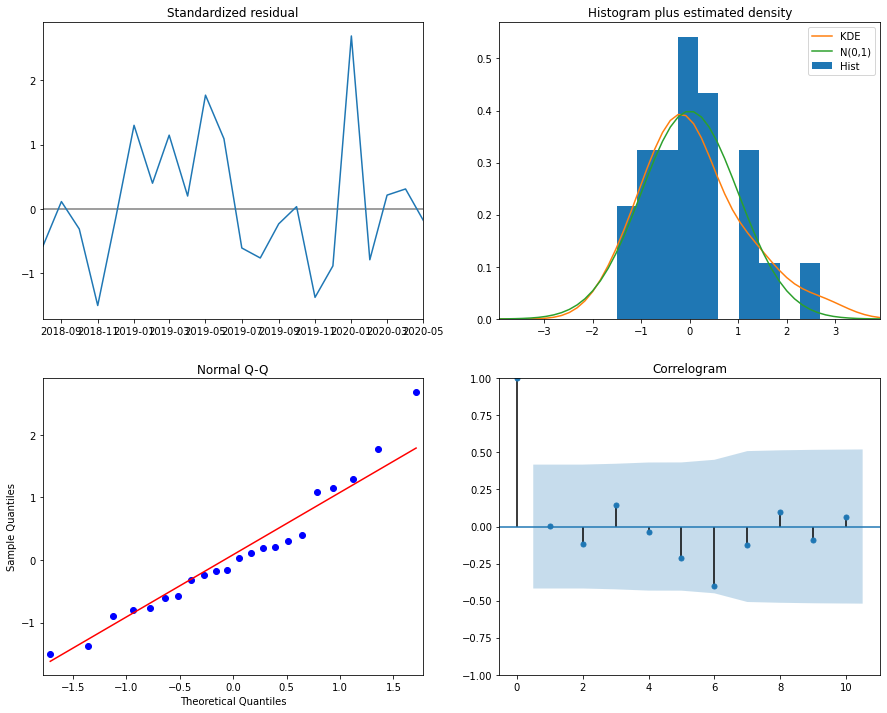

In [ ]:
arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
prediction = arima.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
prediction_intervalle = prediction.conf_int() #Permet de construire un intervalle de confiance pour les paramètres ajustés.

#L'argument dynamic = False garantit que nous produisons des prévisions à une étape,
#ce qui signifie que les prévisions à chaque point sont générées en utilisant l'historique complet jusqu'à ce point.

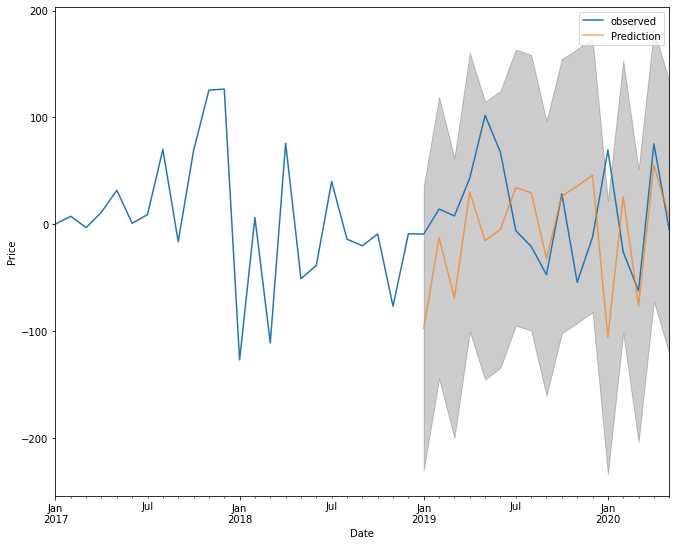

In [ ]:
pred = train['2017':].plot(label='observed')
prediction.predicted_mean.plot(ax=pred, label='Prediction', alpha=.7)

pred.fill_between(prediction_intervalle.index, prediction_intervalle.iloc[:, 0], prediction_intervalle.iloc[:, 1], color='k', alpha=.2)

pred.set_xlabel('Date')
pred.set_ylabel('Price')
plt.legend()

plt.show()

#Dans l'ensemble, nos prévisions ne s'alignent paq tellement à la réalité 
#Cependant le dernier pic et la dernière baissent ont bien été anticipé 

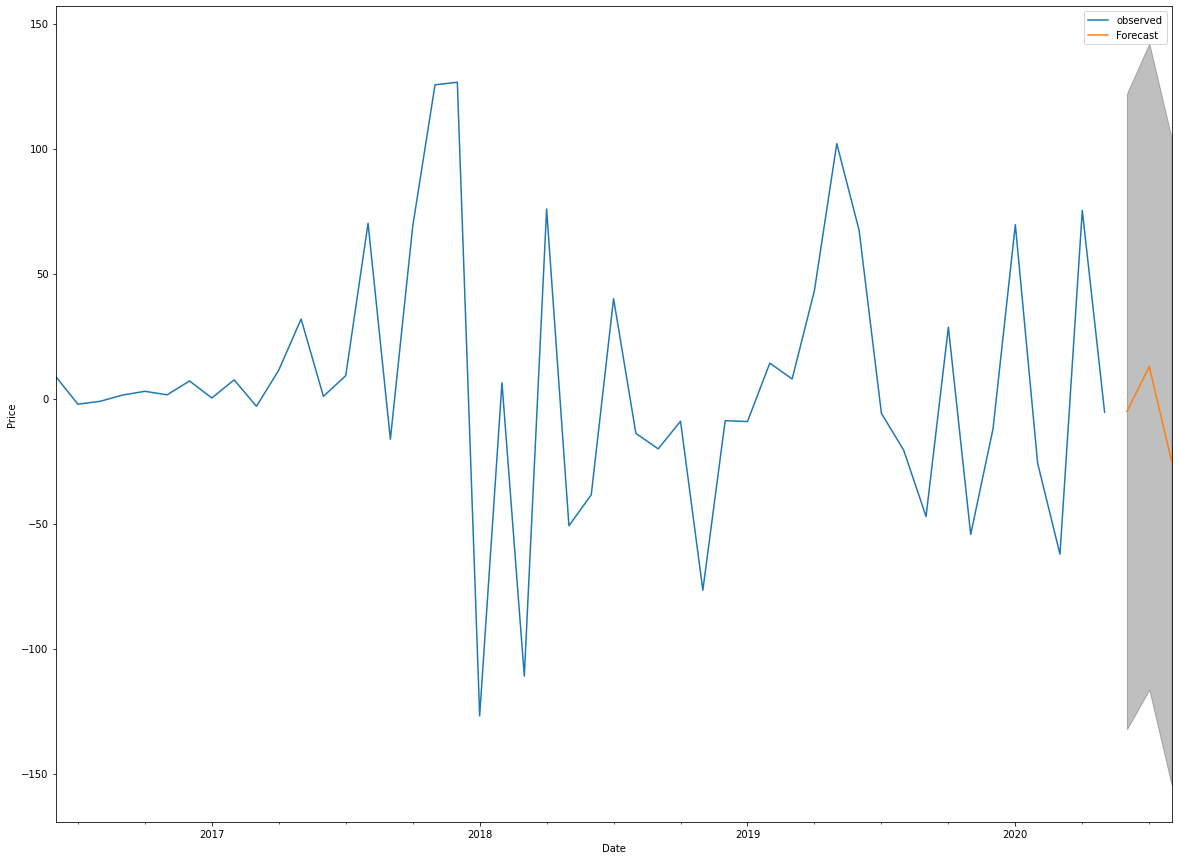

In [ ]:
forecast = arima.get_forecast(steps=3)
forecast_intervalle = forecast.conf_int()

ax = train.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_intervalle.index, forecast_intervalle.iloc[:, 0], forecast_intervalle.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

#Metrics

In [ ]:
predc=(prediction_intervalle["lower Close"]+prediction_intervalle["upper Close"]) /2
predc.index 

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [ ]:
#MSE
#MSE= mean_squared_error(test, predc)



In [ ]:
test.shape

(2,)

In [ ]:
predc=(prediction_intervalle["lower Close"]+prediction_intervalle["upper Close"]) /2
#RMSE : 
rmse = np.mean((predc - test)**2)**.5
rmse

61.77959113603845

In [ ]:
#MAPE
mape = np.mean(np.abs(predc- test)/np.abs(test))  
mape


0.9066627300548389

In [ ]:
#MAE
mae = np.mean(np.abs(predc - test))  
mae 

61.77959113603845

In [ ]:
#MPE 
mpe = np.mean((predc - test)/test)  
mpe 

-0.9066627300548389